In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import os
from itertools import product
from typing import Optional
import math

### Functions

In [2]:
class SkipConv2d:
    def __init__(
        self,
        apply_nan: bool = False,
        padding: int = 0,
        stride: int = 1,
        kernel: torch.Tensor = None,
        bias: torch.Tensor = None,
        precision: np.dtype = torch.float32,
        threshold: Optional[float] = None
    ):
        self.padding = padding
        self.stride = stride
        self.precision = precision
        self.apply_nan = apply_nan
        self.total = 0
        self.skip = 0

        self.kernel = kernel.to(dtype=precision)

        # if threshold is not None:
        self.threshold = threshold
        
        if bias is not None:
            self.bias = bias.to(dtype=precision)
        else:
            self.bias = None


    def __call__(self, input: torch.Tensor) -> torch.Tensor:
        """
        Perform 2D convolution using scalar operations only (no np.sum or broadcasting).
        Args:
            input (torch.Tensor): shape (N, C_in, H_in, W_in)
        Returns:
            output (torch.Tensor): shape (N, C_out, H_out, W_out)
        """
        N, C_in, H_in, W_in = input.shape
        C_out, _, K_h, K_w = self.kernel.shape
        stride = self.stride
        padding = self.padding
        self.C_in = C_in
        self.K_h = K_h
        self.K_w = K_w

        input_padded = torch.nn.functional.pad(input, (self.padding, self.padding, self.padding, self.padding))
        _, _, H_pad, W_pad = input_padded.shape


        H_pad, W_pad = H_in + 2 * padding, W_in + 2 * padding

        H_out = (H_pad - K_h) // stride + 1
        W_out = (W_pad - K_w) // stride + 1
        self.output = torch.zeros((N, C_out, H_out, W_out), dtype=self.precision)


        windows = F.unfold(
            input_padded,
            kernel_size=(K_h, K_w),
            stride=stride
        ) 
        nan_ratio = torch.isnan(windows).sum(dim=1) / windows.shape[1]


        # Count how many can be skipped
        self.skip = (nan_ratio >= self.threshold).sum().item()
        self.total = nan_ratio.numel()
          

        return self.skip, self.total

     

In [ ]:
class Conv2d:
    def __init__(
        self,
        apply_nan: bool = False,
        padding: int = 0,
        stride: int = 1,
        kernel: torch.Tensor = None,
        bias: torch.Tensor = None,
        precision: np.dtype = torch.float32,
        threshold: Optional[float] = None
    ):
        self.padding = padding
        self.stride = stride
        self.precision = precision
        self.apply_nan = apply_nan

        self.kernel = kernel.to(dtype=precision)

        if threshold is not None:
            self.threshold = threshold
        
        if bias is not None:
            self.bias = bias.to(dtype=precision)
        else:
            self.bias = None

    # def manual_conv(self, input_padded, n, c_out, h_out, w_out):

    #     acc = 0.0
    #     for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w)):
    #         i_h = h_out * self.stride + k_h
    #         i_w = w_out * self.stride + k_w
    #         acc += input_padded[n][c_in][i_h][i_w] * self.kernel[c_out][c_in][k_h][k_w]
    #     if self.bias is not None:
    #         acc += self.bias[c_out]

    #     self.output[n][c_out][h_out][w_out] = acc

    
    # def nan_conv(self, input_padded, n, c_out, h_out, w_out):

    #     # Calculate NaN ratio
    #     nan_ratio = torch.isnan(input_padded[n]).sum() / (input_padded[n].size(0) * input_padded[n].size(1) * input_padded[n].size(2))
    #     if nan_ratio >= self.threshold: 
    #         self.count += 1
    #         self.output[n][c_out][h_out][w_out] = float('nan')
    #     else:
    #         acc = 0.0
    #         for c_in in range(self.C_in):
    #             #Calling torch operations to calculate mean and substitution
    #             insert = input_padded[n][c_in][~torch.isnan(input_padded[n][c_in])].flatten()
    #             image_patch = torch.nan_to_num(input_padded[n][c_in], nan=insert.mean())

    #             for k_h in range(self.K_h):
    #                 for k_w in range(self.K_w):
    #                     i_h = h_out * self.stride + k_h
    #                     i_w = w_out * self.stride + k_w
                        
    #                     acc += image_patch[i_h][i_w] * self.kernel[c_out][c_in][k_h][k_w]
    #         if self.bias is not None:
    #             acc += self.bias[c_out]

    #         self.output[n][c_out][h_out][w_out] = acc


    def nan_conv(self, input_padded, n):
        for c_out, h_out, w_out in product(
            range(self.kernel.shape[0]),
            range(self.output.shape[2]),
            range(self.output.shape[3])
        ):
            acc = 0.0
            nan_count = 0
            total_count = 0
            patch_vals = []

            for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w)):
                i_h = h_out * self.stride + k_h
                i_w = w_out * self.stride + k_w
                val = input_padded[n][c_in][i_h][i_w]
                total_count += 1
                if torch.isnan(val):
                    nan_count += 1
                else:
                    patch_vals.append(val)

            nan_ratio = nan_count / total_count
            if self.threshold is not None and nan_ratio >= self.threshold:
                self.output[n][c_out][h_out][w_out] = float('nan')
                continue


            mean_val = torch.stack(patch_vals).mean() if patch_vals else torch.tensor(0.0, dtype=self.precision)

            for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w)):
                i_h = h_out * self.stride + k_h
                i_w = w_out * self.stride + k_w
                val = input_padded[n][c_in][i_h][i_w]
                val = mean_val if torch.isnan(val) else val
                acc += val * self.kernel[c_out][c_in][k_h][k_w]

            if self.bias is not None:
                acc += self.bias[c_out]

            self.output[n][c_out][h_out][w_out] = acc



    def get_val(self, input_padded, mean_val, n, c_in, i_h, i_w):
        val = input_padded[n][c_in][i_h][i_w]
        if self.apply_nan:
            val = mean_val if torch.isnan(val) else val
        return val


    def conv(self, input_padded, n):
        for c_out, h_out, w_out in product(
            range(self.kernel.shape[0]), 
            range(self.output.shape[2]), 
            range(self.output.shape[3])
        ):
            mean_val = None

            if self.apply_nan:
                patch_vals = []
                nan_count = 0
                total_count = self.C_in * self.K_h * self.K_w

                for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w)):
                    i_h = h_out * self.stride + k_h
                    i_w = w_out * self.stride + k_w
                    val = input_padded[n][c_in][i_h][i_w].item()
                    if math.isnan(val):
                        nan_count += 1
                        if self.threshold and nan_count / total_count >= self.threshold:
                            self.output[n][c_out][h_out][w_out] = float('nan')
                            break
                    else:
                        patch_vals.append(val)
                else:
                    mean_val = sum(patch_vals) / len(patch_vals) if patch_vals else 0.0
            # If threshold was exceeded and we broke early, skip this iteration
                if nan_count / total_count >= self.threshold:
                    continue

            # Compute the convolution
            acc = sum([
                self.get_val(input_padded, mean_val, n, c_in, h_out * self.stride + k_h, w_out * self.stride + k_w) *
                self.kernel[c_out][c_in][k_h][k_w].item()
                for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w))
            ])

            if self.bias is not None:
                acc += self.bias[c_out].item()

            self.output[n][c_out][h_out][w_out] = acc

    def optimized_conv(self, input_padded):
        N, C_in, H_padded, W_padded = input_padded.shape
        C_out, _, K_h, K_w = self.kernel.shape
        H_out = (H_padded - K_h) // self.stride + 1
        W_out = (W_padded - K_w) // self.stride + 1

        # # Initialize output
        # output = torch.zeros(N, C_out, H_out, W_out, device=input_padded.device)

        # Fast path: If no NaN handling is needed
        if not self.apply_nan and not self.threshold:
            # Standard convolution using unfold + matmul
            for n in range(N):
                # Extract all windows in one go
                windows = F.unfold(
                    input_padded[n:n+1],
                    kernel_size=(K_h, K_w),
                    stride=self.stride
                )

                # Reshape to [H_out*W_out, C_in*K_h*K_w]
                windows = windows.squeeze(0).transpose(0, 1)

                # Reshape kernel for batch matmul: [C_out, C_in*K_h*K_w]
                kernel_flat = self.kernel.reshape(C_out, -1)

                # Calculate all output positions at once
                result = torch.matmul(kernel_flat, windows.transpose(0, 1))

                if self.bias is not None:
                    result = result + self.bias.view(C_out, 1)

                # Reshape back to output dimensions
                self.output[n] = result.view(C_out, H_out, W_out)

            return self.output

        # NaN handling path
        for n in range(N):
            # Extract all windows in one go
            windows = F.unfold(
                input_padded[n:n+1],
                kernel_size=(K_h, K_w),
                stride=self.stride
            )

            # Reshape to [H_out*W_out, C_in*K_h*K_w]
            windows = windows.squeeze(0).transpose(0, 1)

            # Count NaNs in each window
            nan_mask = torch.isnan(windows)
            nan_counts = nan_mask.sum(dim=1)
            total_count = C_in * K_h * K_w

            # Check threshold
            if self.threshold:
                exceed_threshold = (nan_counts / total_count) >= self.threshold
            else:
                exceed_threshold = torch.zeros(windows.shape[0], dtype=torch.bool, device=windows.device)

            # Handle NaNs if needed
            if self.apply_nan:
                for i in range(len(windows)):
                    if not exceed_threshold[i]:
                        # Calculate mean of non-NaN values
                        valid_values = windows[i][~nan_mask[i]]
                        mean_val = valid_values.mean() if len(valid_values) > 0 else 0.0
                        # Replace NaNs with mean
                        windows[i] = torch.where(nan_mask[i], torch.tensor(mean_val, device=windows.device), windows[i])

            # Reshape kernel for batch matmul: [C_out, C_in*K_h*K_w]
            kernel_flat = self.kernel.reshape(C_out, -1)

            # Process each window
            for i, (h_out, w_out) in enumerate(product(range(H_out), range(W_out))):
                if exceed_threshold[i]:
                    self.output[n, :, h_out, w_out] = float('nan')
                else:
                    # Compute for all output channels at once
                    if self.bias is not None:
                        self.output[n, :, h_out, w_out] = torch.matmul(kernel_flat, windows[i]) + self.bias
                    else:
                        self.output[n, :, h_out, w_out] = torch.matmul(kernel_flat, windows[i])

        return self.output



    def __call__(self, input: torch.Tensor) -> torch.Tensor:
        """
        Perform 2D convolution using scalar operations only (no np.sum or broadcasting).
        Args:
            input (torch.Tensor): shape (N, C_in, H_in, W_in)
        Returns:
            output (torch.Tensor): shape (N, C_out, H_out, W_out)
        """
        N, C_in, H_in, W_in = input.shape
        C_out, _, K_h, K_w = self.kernel.shape
        stride = self.stride
        padding = self.padding
        self.C_in = C_in
        self.K_h = K_h
        self.K_w = K_w

        input_padded = torch.nn.functional.pad(input, (self.padding, self.padding, self.padding, self.padding))
        _, _, H_pad, W_pad = input_padded.shape


        H_pad, W_pad = H_in + 2 * padding, W_in + 2 * padding

        H_out = (H_pad - K_h) // stride + 1
        W_out = (W_pad - K_w) // stride + 1
        self.output = torch.zeros((N, C_out, H_out, W_out), dtype=self.precision)

        [self.conv(input_padded, n) for n in range(N) ]
        

        # if self.apply_nan:
        #     [self.nan_conv(input_padded, n) for n in range(N) ]
        #     # [self.nan_conv(input_padded, n, c_out, h_out, w_out) for n, c_out, h_out, w_out in product(range(N), range(C_out), range(H_out), range(W_out)) ]
        # else:
        #     [self.manual_conv(input_padded, n, c_out, h_out, w_out) for n, c_out, h_out, w_out in product(range(N), range(C_out), range(H_out), range(W_out)) ]

        return self.output


In [10]:
class ManualConv2d:
    def __init__(
        self,
        padding: int = 0,
        stride: int = 1,
        kernel: torch.Tensor = None,
        bias: torch.Tensor = None,
        precision: np.dtype = torch.float32
    ):
        self.padding = padding
        self.stride = stride
        self.precision = precision

        self.kernel = kernel.to(dtype=precision)
        
        if bias is not None:
            self.bias = bias.to(dtype=precision)
        else:
            self.bias = None

    def __call__(self, input: torch.Tensor) -> torch.Tensor:
        """
        Perform 2D convolution using scalar operations only (no np.sum or broadcasting).
        Args:
            input (torch.Tensor): shape (N, C_in, H_in, W_in)
        Returns:
            output (torch.Tensor): shape (N, C_out, H_out, W_out)
        """
        N, C_in, H_in, W_in = input.shape
        C_out, _, K_h, K_w = self.kernel.shape
        stride = self.stride
        padding = self.padding

        input_padded = torch.nn.functional.pad(input, (self.padding, self.padding, self.padding, self.padding))
        _, _, H_pad, W_pad = input_padded.shape


        H_pad, W_pad = H_in + 2 * padding, W_in + 2 * padding
        output = torch.zeros((N, C_in, H_pad, W_pad), dtype=self.precision)


        H_out = (H_pad - K_h) // stride + 1
        W_out = (W_pad - K_w) // stride + 1
        output = torch.zeros((N, C_out, H_out, W_out), dtype=self.precision)

        for n in range(N):
            for c_out in range(C_out):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        acc = 0.0
                        for c_in in range(C_in):
                            for k_h in range(K_h):
                                for k_w in range(K_w):
                                    i_h = h_out * stride + k_h
                                    i_w = w_out * stride + k_w
                                    acc += input_padded[n][c_in][i_h][i_w] * self.kernel[c_out][c_in][k_h][k_w]
                        if self.bias is not None:
                            acc += self.bias[c_out]
                        output[n][c_out][h_out][w_out] = acc

        return output


In [11]:
class NaNConv2d(nn.Module):
    def __init__(
        self,
        padding: int = 0,
        stride: int = 1,
        threshold: float = 0.5,
        kernel: torch.Tensor = None,
        bias: torch.Tensor = None,
        precision: torch.dtype = torch.float32
    ):
        super().__init__()
        self.stride = stride
        self.padding = padding
        self.threshold = threshold
        self.precision = precision

        self.kernel = kernel.to(dtype=precision)
        self.bias = bias.to(dtype=precision) if bias is not None else None

        self.out_channels, self.in_channels, self.kh, self.kw = self.kernel.shape

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))
        B, C, H, W = x.shape

        oh = (H - self.kh) // self.stride + 1
        ow = (W - self.kw) // self.stride + 1

        output = torch.empty(B, self.out_channels, oh, ow, dtype=self.precision)

        for b in range(B):
            for oc in range(self.out_channels):
                for i in range(oh):
                    for j in range(ow):
                        x_start = i * self.stride
                        y_start = j * self.stride

                        nan_count = 0
                        total = 0
                        val_sum = 0.0
                        patch_vals = []  # buffer for mean-substitution pass

                        # First pass: gather patch and compute stats
                        for ic in range(self.in_channels):
                            for m in range(self.kh):
                                for n in range(self.kw):
                                    val = x[b][ic][x_start + m][y_start + n]
                                    patch_vals.append((ic, m, n, val))
                                    total += 1
                                    if torch.isnan(val):
                                        nan_count += 1
                                    else:
                                        val_sum += float(val)

                        nan_ratio = nan_count / total
                        if nan_ratio >= self.threshold or total == nan_count:
                            output[b][oc][i][j] = float('nan')
                            continue

                        patch_mean = val_sum / (total - nan_count)
                        conv_sum = 0.0

                        # Convolution with mean-substitution
                        for ic, m, n, val in patch_vals:
                            val = patch_mean if torch.isnan(val) else float(val)
                            kval = float(self.kernel[oc][ic][m][n])
                            conv_sum += val * kval

                        if self.bias is not None:
                            conv_sum += float(self.bias[oc])

                        output[b][oc][i][j] = conv_sum

        return output


In [2]:
def conv(self, input_padded, n, apply_nan=False):
    for c_out, h_out, w_out in product(range(self.kernel.shape[0]), range(self.output.shape[2]), range(self.output.shape[3])):
        acc = 0.0
        mean_val=None
        if apply_nan:
            nan_count = 0
            total_count = 0
            patch_vals = []

            for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w)):
                i_h = h_out * self.stride + k_h
                i_w = w_out * self.stride + k_w
                val = input_padded[n][c_in][i_h][i_w]
                total_count += 1
                if torch.isnan(val):
                    nan_count += 1
                else:
                    patch_vals.append(val)

            nan_ratio = nan_count / total_count
            if self.threshold is not None and nan_ratio >= self.threshold:
                self.output[n][c_out][h_out][w_out] = float('nan')
                continue


            mean_val = torch.stack(patch_vals).mean() if patch_vals else torch.tensor(0.0, dtype=self.precision)

        acc = sum([self.get_val(input_padded, apply_nan, mean_val, n,c_in, k_h, k_w) for c_in,k_h,k_w in product( range(self.C_in), range(self.K_h), range(self.K_w) )])

        # for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w)):
        #     i_h = h_out * self.stride + k_h
        #     i_w = w_out * self.stride + k_w
        #     val = input_padded[n][c_in][i_h][i_w]
        #     if apply_nan:
        #         val = mean_val if torch.isnan(val) else val
        #     acc += val * self.kernel[c_out][c_in][k_h][k_w]
            
        if self.bias is not None:
            acc += self.bias[c_out]

        self.output[n][c_out][h_out][w_out] = acc


def conv(self, input_padded, n):
    for c_out, h_out, w_out in product(range(self.kernel.shape[0]), range(self.output.shape[2]), range(self.output.shape[3])):
        acc = 0.0
        mean_val = None

        if self.apply_nan:
            patch_vals = []
            nan_count = 0
            total_count = self.C_in * self.K_h * self.K_w

            for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w)):
                i_h = h_out * self.stride + k_h
                i_w = w_out * self.stride + k_w
                val = input_padded[n][c_in][i_h][i_w]
                if torch.isnan(val):
                    nan_count += 1
                    if self.threshold and nan_count / total_count >= self.threshold:
                        self.output[n][c_out][h_out][w_out] = float('nan')
                        break
                else:
                    patch_vals.append(val)
            

            mean_val = sum(patch_vals) / len(patch_vals) if patch_vals else 0.0

        acc = sum([self.get_val(input_padded, mean_val, n, c_in, h_out * self.stride + k_h, w_out * self.stride + k_w)*self.kernel[c_out][c_in][k_h][k_w] for c_in,k_h,k_w in product( range(self.C_in), range(self.K_h), range(self.K_w) )])

        # for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w)):
        #     i_h = h_out * self.stride + k_h
        #     i_w = w_out * self.stride + k_w
        #     val = input_padded[n][c_in][i_h][i_w].item()
        #     acc += val * self.kernel[c_out][c_in][k_h][k_w].item()

        if self.bias is not None:
            acc += self.bias[c_out]

        self.output[n][c_out][h_out][w_out] = acc
    

def conv(self, input_padded, n):



    for c_out, h_out, w_out in product(range(self.kernel.shape[0]), range(self.output.shape[2]), range(self.output.shape[3])):
        acc = 0.0
        mean_val = None

        # Extract patch (C_in, K_h, K_w) around the current location
        i_h_start = h_out * self.stride
        i_w_start = w_out * self.stride
        i_h_end = i_h_start + self.K_h
        i_w_end = i_w_start + self.K_w

        patch = input_padded[n, :, i_h_start:i_h_end, i_w_start:i_w_end]  # Shape: (C_in, K_h, K_w)


        if self.apply_nan:
            nan_mask = torch.isnan(patch)
            nan_ratio = nan_mask.sum().float() / patch.numel()

            if self.threshold and nan_ratio >= self.threshold:
                self.output[n][c_out][h_out][w_out] = float('nan')
                continue

            if nan_mask.any():
                # Use masked_select instead of boolean indexing for speed
                valid_vals = torch.masked_select(patch, ~nan_mask)

                # Avoid creating a new tensor for 0.0 when patch is fully NaN
                if valid_vals.numel() == 0:
                    mean_val = 0.0
                else:
                    mean_val = valid_vals.mean()

                patch = torch.where(nan_mask, mean_val, patch)

        # Perform convolution: element-wise multiply and sum
        acc = (patch * self.kernel[c_out]).sum()

        # acc = sum([self.get_val(input_padded, mean_val, n, c_in, h_out * self.stride + k_h, w_out * self.stride + k_w)*self.kernel[c_out][c_in][k_h][k_w] for c_in,k_h,k_w in product( range(self.C_in), range(self.K_h), range(self.K_w) )])

        # for c_in, k_h, k_w in product(range(self.C_in), range(self.K_h), range(self.K_w)):
        #     i_h = h_out * self.stride + k_h
        #     i_w = w_out * self.stride + k_w
        #     val = input_padded[n][c_in][i_h][i_w].item()
        #     acc += val * self.kernel[c_out][c_in][k_h][k_w].item()

        if self.bias is not None:
            acc += self.bias[c_out]

        self.output[n][c_out][h_out][w_out] = acc




In [8]:
# Conv torch.Size([1, 32, 256, 256])
# Conv 0 torch.Size([71, 32, 3, 3])
# Each input channel takes 7 mins, i.e. 7*71=497 mins

input_tensor = torch.rand(1, 71, 32, 32)
kernel = torch.rand(71, 71, 3, 3)

# Instantiate the NaN-aware convolution
manualconv = Conv2d(
    apply_nan=False,
    padding=1,
    stride=1,
    kernel=kernel,
)

# Time the execution
start_time = time.time()
output = manualconv(input_tensor)
end_time = time.time()

# Print the output and timing
print("Output:\n", output.shape)
print("Elapsed time: {:.6f} seconds".format(end_time - start_time))

Output:
 torch.Size([1, 71, 32, 32])
Elapsed time: 994.262048 seconds


In [8]:
matrix_size = 200
nan_presence = 2
input_tensor = torch.rand(1,1,matrix_size,matrix_size)
# input_tensor = insert_nans(input_tensor, percentage=(1 - ( matrix_size//nan_presence)/matrix_size))
input_tensor = insert_border_nans_until_percentage(input_tensor, percentage=(1 - ( matrix_size//nan_presence)/matrix_size))
# plt.imshow(input_tensor.squeeze())
print(input_tensor)

print(f'Input tensor shape: {input_tensor.shape}')

# Define a simple kernel (out_channels=1, in_channels=1, 2x2 kernel)
# kernel = torch.tensor([[[[1.0, 0.0],
#                 [0.0, -1.0]],
#                 [[1.0, 0.0],
#                 [0.0, -1.0]]]])

kernel = torch.tensor([[[[1.0, 0.0],
                [0.0, -1.0]],]])

print(f'Kernel tensor shape: {kernel.shape}')


# Instantiate the NaN-aware convolution
nanconv = Conv2d(
    apply_nan=True,
    padding=0,
    stride=1,
    kernel=kernel,
    threshold=0.5,
)

# Time the execution
start_time = time.time()
output = nanconv(input_tensor)
end_time = time.time()

# Print the output and timing
# print("Output:\n", output)
print("Elapsed time: {:.6f} seconds".format(end_time - start_time))



# Instantiate the NaN-aware convolution
manualconv = Conv2d(
    apply_nan=False,
    padding=0,
    stride=1,
    kernel=kernel,
)

# Time the execution
start_time = time.time()
output = manualconv(input_tensor)
end_time = time.time()

# Print the output and timing
# print("Output:\n", output)
print("Elapsed time: {:.6f} seconds".format(end_time - start_time))

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]])
Input tensor shape: torch.Size([1, 1, 200, 200])
Kernel tensor shape: torch.Size([1, 1, 2, 2])
Elapsed time: 3.279500 seconds
Elapsed time: 3.886736 seconds


### Small Test Cases for Accuracy of Functions

In [12]:
# Define small dummy input with NaNs
input_tensor = torch.tensor([[[[1.0, 2.0, 3.0],
                [4.0, 5.0, 6.0],
                [7.0, 8.0, 9.0]]]])

print(f'Input tensor shape: {input_tensor.shape}')

# Define a simple kernel (out_channels=1, in_channels=1, 2x2 kernel)
kernel = torch.tensor([[[[2.0, 1.0],
                [0.0, -2.0]]]])

print(f'Kernel tensor shape: {kernel.shape}')


# Instantiate the NaN-aware convolution
nanconv = Conv2d(
    apply_nan=True,
    padding=0,
    stride=1,
    kernel=kernel,
    threshold=0.5,
)

# Time the execution
start_time = time.time()
output = nanconv(input_tensor)
end_time = time.time()

# Print the output and timing
print("Output:\n", output)
print("Elapsed time: {:.6f} seconds".format(end_time - start_time))



# Instantiate the NaN-aware convolution
manualconv = Conv2d(
    apply_nan=False,
    padding=0,
    stride=1,
    kernel=kernel,
)

# Time the execution
start_time = time.time()
output = manualconv(input_tensor)
end_time = time.time()

# Print the output and timing
print("Output:\n", output)
print("Elapsed time: {:.6f} seconds".format(end_time - start_time))

Input tensor shape: torch.Size([1, 1, 3, 3])
Kernel tensor shape: torch.Size([1, 1, 2, 2])
Output:
 tensor([[[[-6., -5.],
          [-3., -2.]]]])
Elapsed time: 0.002403 seconds
Output:
 tensor([[[[-6., -5.],
          [-3., -2.]]]])
Elapsed time: 0.000853 seconds


In [11]:
input_tensor = torch.tensor([[[[1.0, 2.0, 3.0],
                [4.0, 5.0, 6.0],
                [7.0, 8.0, 9.0]]]])

print(f'Input tensor shape: {input_tensor.shape}')

# Define a simple kernel (out_channels=1, in_channels=1, 2x2 kernel)
kernel = torch.tensor([[[[2.0, 1.0],
                [0.0, -2.0]]]])

torch.nn.functional.conv2d(input=input_tensor, weight=kernel, stride=1, padding=0)

Input tensor shape: torch.Size([1, 1, 3, 3])


tensor([[[[-6., -5.],
          [-3., -2.]]]])

In [13]:
# Define small dummy input with NaNs
input_tensor = torch.tensor([[
  [[1.0, 2.0],
   [3.0, 4.0]],
  [[5.0, 6.0],
   [7.0, 8.0]]
]])

print(f'Input tensor shape: {input_tensor.shape}')

# Define a simple kernel (out_channels=1, in_channels=1, 2x2 kernel)
kernel = torch.tensor([[
  [[1.0, 0.0],
   [0.0, -1.0]],
  [[-1.0, 0.0],
   [0.0, 1.0]]
]])

print(f'Kernel tensor shape: {kernel.shape}')


# Instantiate the NaN-aware convolution
nanconv = Conv2d(
    apply_nan=True,
    padding=1,
    stride=1,
    kernel=kernel,
    threshold=0.5,
)

# Time the execution
start_time = time.time()
output = nanconv(input_tensor)
end_time = time.time()

# Print the output and timing
print("Output:\n", output)
print("Elapsed time: {:.6f} seconds".format(end_time - start_time))



# Instantiate the NaN-aware convolution
manualconv = Conv2d(
    apply_nan=False,
    padding=1,
    stride=1,
    kernel=kernel,
)

# Time the execution
start_time = time.time()
output = manualconv(input_tensor)
end_time = time.time()

# Print the output and timing
print("Output:\n", output)
print("Elapsed time: {:.6f} seconds".format(end_time - start_time))

Input tensor shape: torch.Size([1, 2, 2, 2])
Kernel tensor shape: torch.Size([1, 2, 2, 2])
Output:
 tensor([[[[ 4.,  4.,  0.],
          [ 4.,  0., -4.],
          [ 0., -4., -4.]]]])
Elapsed time: 0.006713 seconds
Output:
 tensor([[[[ 4.,  4.,  0.],
          [ 4.,  0., -4.],
          [ 0., -4., -4.]]]])
Elapsed time: 0.002281 seconds


In [16]:
input_tensor = torch.tensor([[
  [[1.0, 2.0],
   [3.0, 4.0]],
  [[5.0, 6.0],
   [7.0, 8.0]]
]])

print(f'Input tensor shape: {input_tensor.shape}')

# Define a simple kernel (out_channels=1, in_channels=1, 2x2 kernel)
kernel = torch.tensor([[
  [[1.0, 0.0],
   [0.0, -1.0]],
  [[-1.0, 0.0],
   [0.0, 1.0]]
]])

torch.nn.functional.conv2d(input=input_tensor, weight=kernel, stride=1, padding=1)

Input tensor shape: torch.Size([1, 2, 2, 2])


tensor([[[[ 4.,  4.,  0.],
          [ 4.,  0., -4.],
          [ 0., -4., -4.]]]])

In [80]:
# Define small dummy input with NaNs
input_tensor = torch.tensor(
    [[[[1.0, 2.0, float('nan')],
       [4.0, float('nan'), 6.0],
       [7.0, 8.0, 9.0]]]],
    dtype=torch.float32)

bias = torch.tensor([0.5], dtype=torch.float32)

print(f'Input tensor shape: {input_tensor.shape}')

# Define a simple kernel (out_channels=1, in_channels=1, 2x2 kernel)
kernel = torch.tensor(
        [[[[1.0, 0.0],
        [0.0, -1.0]]]],
        dtype=torch.float32
    )

print(f'Kernel tensor shape: {kernel.shape}')


# Instantiate the NaN-aware convolution
nanconv = Conv2d(
    apply_nan=True,
    padding=1,
    stride=1,
    kernel=kernel,
    bias=bias,
    threshold=0.5,
)

# Time the execution
start_time = time.time()
output = nanconv(input_tensor)
end_time = time.time()

# Print the output and timing
print("Output:\n", output)
print("Elapsed time: {:.6f} seconds".format(end_time - start_time))



# Instantiate the NaN-aware convolution
manualconv = Conv2d(
    apply_nan=False,
    padding=1,
    stride=1,
    kernel=kernel,
    bias=bias,
)

# Time the execution
start_time = time.time()
output = manualconv(input_tensor)
end_time = time.time()

# Print the output and timing
print("Output:\n", output)
print("Elapsed time: {:.6f} seconds".format(end_time - start_time))

Input tensor shape: torch.Size([1, 1, 3, 3])
Kernel tensor shape: torch.Size([1, 1, 2, 2])
Output:
 tensor([[[[-0.5000, -1.5000, -0.1667,  0.5000],
          [-3.5000, -0.8333,     nan,  2.5000],
          [-6.5000, -3.5000, -0.8333,  6.5000],
          [ 0.5000,  7.5000,  8.5000,  9.5000]]]])
Elapsed time: 0.004081 seconds
Output:
 tensor([[[[-0.5000, -1.5000,     nan,     nan],
          [-3.5000,     nan,     nan,     nan],
          [-6.5000,     nan,     nan,  6.5000],
          [ 0.5000,  7.5000,  8.5000,  9.5000]]]])
Elapsed time: 0.001982 seconds


In [15]:
input_tensor = torch.tensor(
    [[[[1.0, 2.0, float('nan')],
       [4.0, float('nan'), 6.0],
       [7.0, 8.0, 9.0]]]],
    dtype=torch.float32)

bias = torch.tensor([0.5], dtype=torch.float32)

print(f'Input tensor shape: {input_tensor.shape}')

# Define a simple kernel (out_channels=1, in_channels=1, 2x2 kernel)
kernel = torch.tensor(
        [[[[1.0, 0.0],
        [0.0, -1.0]]]],
        dtype=torch.float32
    )

torch.nn.functional.conv2d(input=input_tensor, weight=kernel, bias=bias, stride=1, padding=1)

Input tensor shape: torch.Size([1, 1, 3, 3])


tensor([[[[-0.5000, -1.5000,     nan,     nan],
          [-3.5000,     nan,     nan,     nan],
          [-6.5000,     nan,     nan,  6.5000],
          [ 0.5000,  7.5000,  8.5000,  9.5000]]]])

### Evaluating Speed Up

In [3]:
def insert_border_nans_until_percentage(tensor: torch.Tensor, percentage: float):
    assert tensor.dim() == 4, "Expected tensor of shape (N, C, H, W)"
    N, C, H, W = tensor.shape
    total_elements = N * C * H * W
    num_nans_target = int(total_elements * percentage)

    nan_count = 0
    border_width = 0
    mask = torch.zeros((H, W), dtype=torch.bool)

    while nan_count < num_nans_target:

        border_width += 1

        # Create a new border mask layer
        new_mask = torch.zeros_like(mask)
        new_mask[:border_width, :] = True     # top
        new_mask[-border_width:, :] = True    # bottom
        new_mask[:, :border_width] = True     # left
        new_mask[:, -border_width:] = True    # right

        # Add new border layer (exclude already masked areas)
        to_add = new_mask & (~mask)
        new_pixels = to_add.sum().item() * N * C
        mask |= to_add
        nan_count += new_pixels

    # Apply NaNs to selected border positions for all N, C
    for n in range(N):
        for c in range(C):
            tensor[n, c][mask] = float('nan')

    return tensor

def insert_nans(tensor: torch.Tensor, percentage: float):
    """
    Randomly inserts NaNs into the tensor with each element having 
    `percentage` chance of becoming NaN.

    Args:
        tensor (torch.Tensor): Input tensor.
        percentage (float): Probability (between 0 and 1) that each element becomes NaN.

    Returns:
        torch.Tensor: Tensor with some elements set to NaN.
    """
    mask = torch.rand_like(tensor) < percentage
    tensor[mask] = float('nan')
    return tensor

# matrix_size = 10
# nan_presence = 2
# input_tensor = torch.rand(1,1,matrix_size,matrix_size)
# input_tensor = insert_nans(input_tensor, percentage=(1 - ( matrix_size//nan_presence)/matrix_size))
# plt.imshow(input_tensor.squeeze())


for nan_presence in [1.5, 2,3,4,5,6,7,8,9,10]:
# for nan_presence in [2,3,4,]:

    for matrix_size in [5,10,20,50,100,200,500,1000]:

        input_tensor = torch.rand(1,1,matrix_size,matrix_size)
        input_tensor1 = insert_border_nans_until_percentage(input_tensor, 1 - ( matrix_size//nan_presence)/matrix_size )
        input_tensor2 = insert_nans(input_tensor, percentage=(1 - ( matrix_size//nan_presence)/matrix_size))
        print('Structured NaNs', 1 - ( matrix_size//nan_presence)/matrix_size  , (torch.isnan(input_tensor1).sum() / input_tensor1.numel()).item() )
        print('Random Index NaNs', 1 - ( matrix_size//nan_presence)/matrix_size  , (torch.isnan(input_tensor2).sum() / input_tensor2.numel()).item() )
    print()
    break

Structured NaNs 0.4 0.800000011920929
Random Index NaNs 0.4 0.800000011920929
Structured NaNs 0.4 0.800000011920929
Random Index NaNs 0.4 0.800000011920929
Structured NaNs 0.35 0.5525000095367432
Random Index NaNs 0.35 0.5525000095367432
Structured NaNs 0.33999999999999997 0.5888000130653381
Random Index NaNs 0.33999999999999997 0.5888000130653381
Structured NaNs 0.33999999999999997 0.5777999758720398
Random Index NaNs 0.33999999999999997 0.5777999758720398
Structured NaNs 0.33499999999999996 0.5650249719619751
Random Index NaNs 0.33499999999999996 0.5650249719619751
Structured NaNs 0.33399999999999996 0.5567359924316406
Random Index NaNs 0.33399999999999996 0.5567359924316406
Structured NaNs 0.33399999999999996 0.5564699769020081
Random Index NaNs 0.33399999999999996 0.5564699769020081



#### Main Figures

**NaN Convolution Time Trials on CPU + Speed Up Conversion to Skipped Convolutions**

In [ ]:
selected_nan_presences = [1.5,2,4,10]
input_sizes = [20,200,500,1000]


skip_cputime_nan_idx = {k: [] for k in selected_nan_presences }
skip_cputime_nan_struct = {k: [] for k in selected_nan_presences }
# skip_cputime_nan_idx_bfloat = {k: [] for k in selected_nan_presences }
# skip_cputime_nan_struct_bfloat = {k: [] for k in selected_nan_presences }

kernel = torch.tensor([[[[1.0, 0.0],
                [0.0, -1.0]],]])

for nan_presence in selected_nan_presences:
  random_stack = []
  struct_stack = []

  for i in range(1, 11):

    random_array = []
    struct_array = []
    for matrix_size in input_sizes:

      input_tensor = torch.rand(1,1,matrix_size,matrix_size)
      input_tensor1 = insert_border_nans_until_percentage(input_tensor, 1 - ( matrix_size//nan_presence)/matrix_size ) #structured
      input_tensor = torch.rand(1,1,matrix_size,matrix_size)
      input_tensor2 = insert_nans(input_tensor, percentage=(1 - ( matrix_size//nan_presence)/matrix_size)) #randomized

            
      nanconv = SkipConv2d(
          apply_nan=True,
          padding=0,
          stride=1,
          kernel=kernel,
          threshold=0.5,
      )

      skip,total = nanconv(input_tensor1)
      random_array.append(skip/total)

      skip,total = nanconv(input_tensor2)
      struct_array.append(skip/total)

    random_stack.append(random_array)
    struct_stack.append(struct_array)
        
  skip_cputime_nan_idx[nan_presence].append(random_stack)
  skip_cputime_nan_struct[nan_presence].append(struct_stack)


/tmp/ipykernel_3238689/720590876.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2')


1.5 [0.01332733 0.04761879 0.34432425 9.18578759]
1.5 [0.00905958 0.04021045 0.26978703 7.29342788]
2 [0.00887101 0.03689975 0.2211064  6.17385939]
2 [0.00878091 0.0387222  0.25925602 7.0150977 ]
4 [0.00374317 0.01730942 0.12083059 3.30840893]
4 [0.00866615 0.03850839 0.2568548  6.99587168]
10 [0.00331355 0.01413192 0.09357023 2.57807398]
10 [0.00868226 0.03838266 0.25492129 6.95906122]


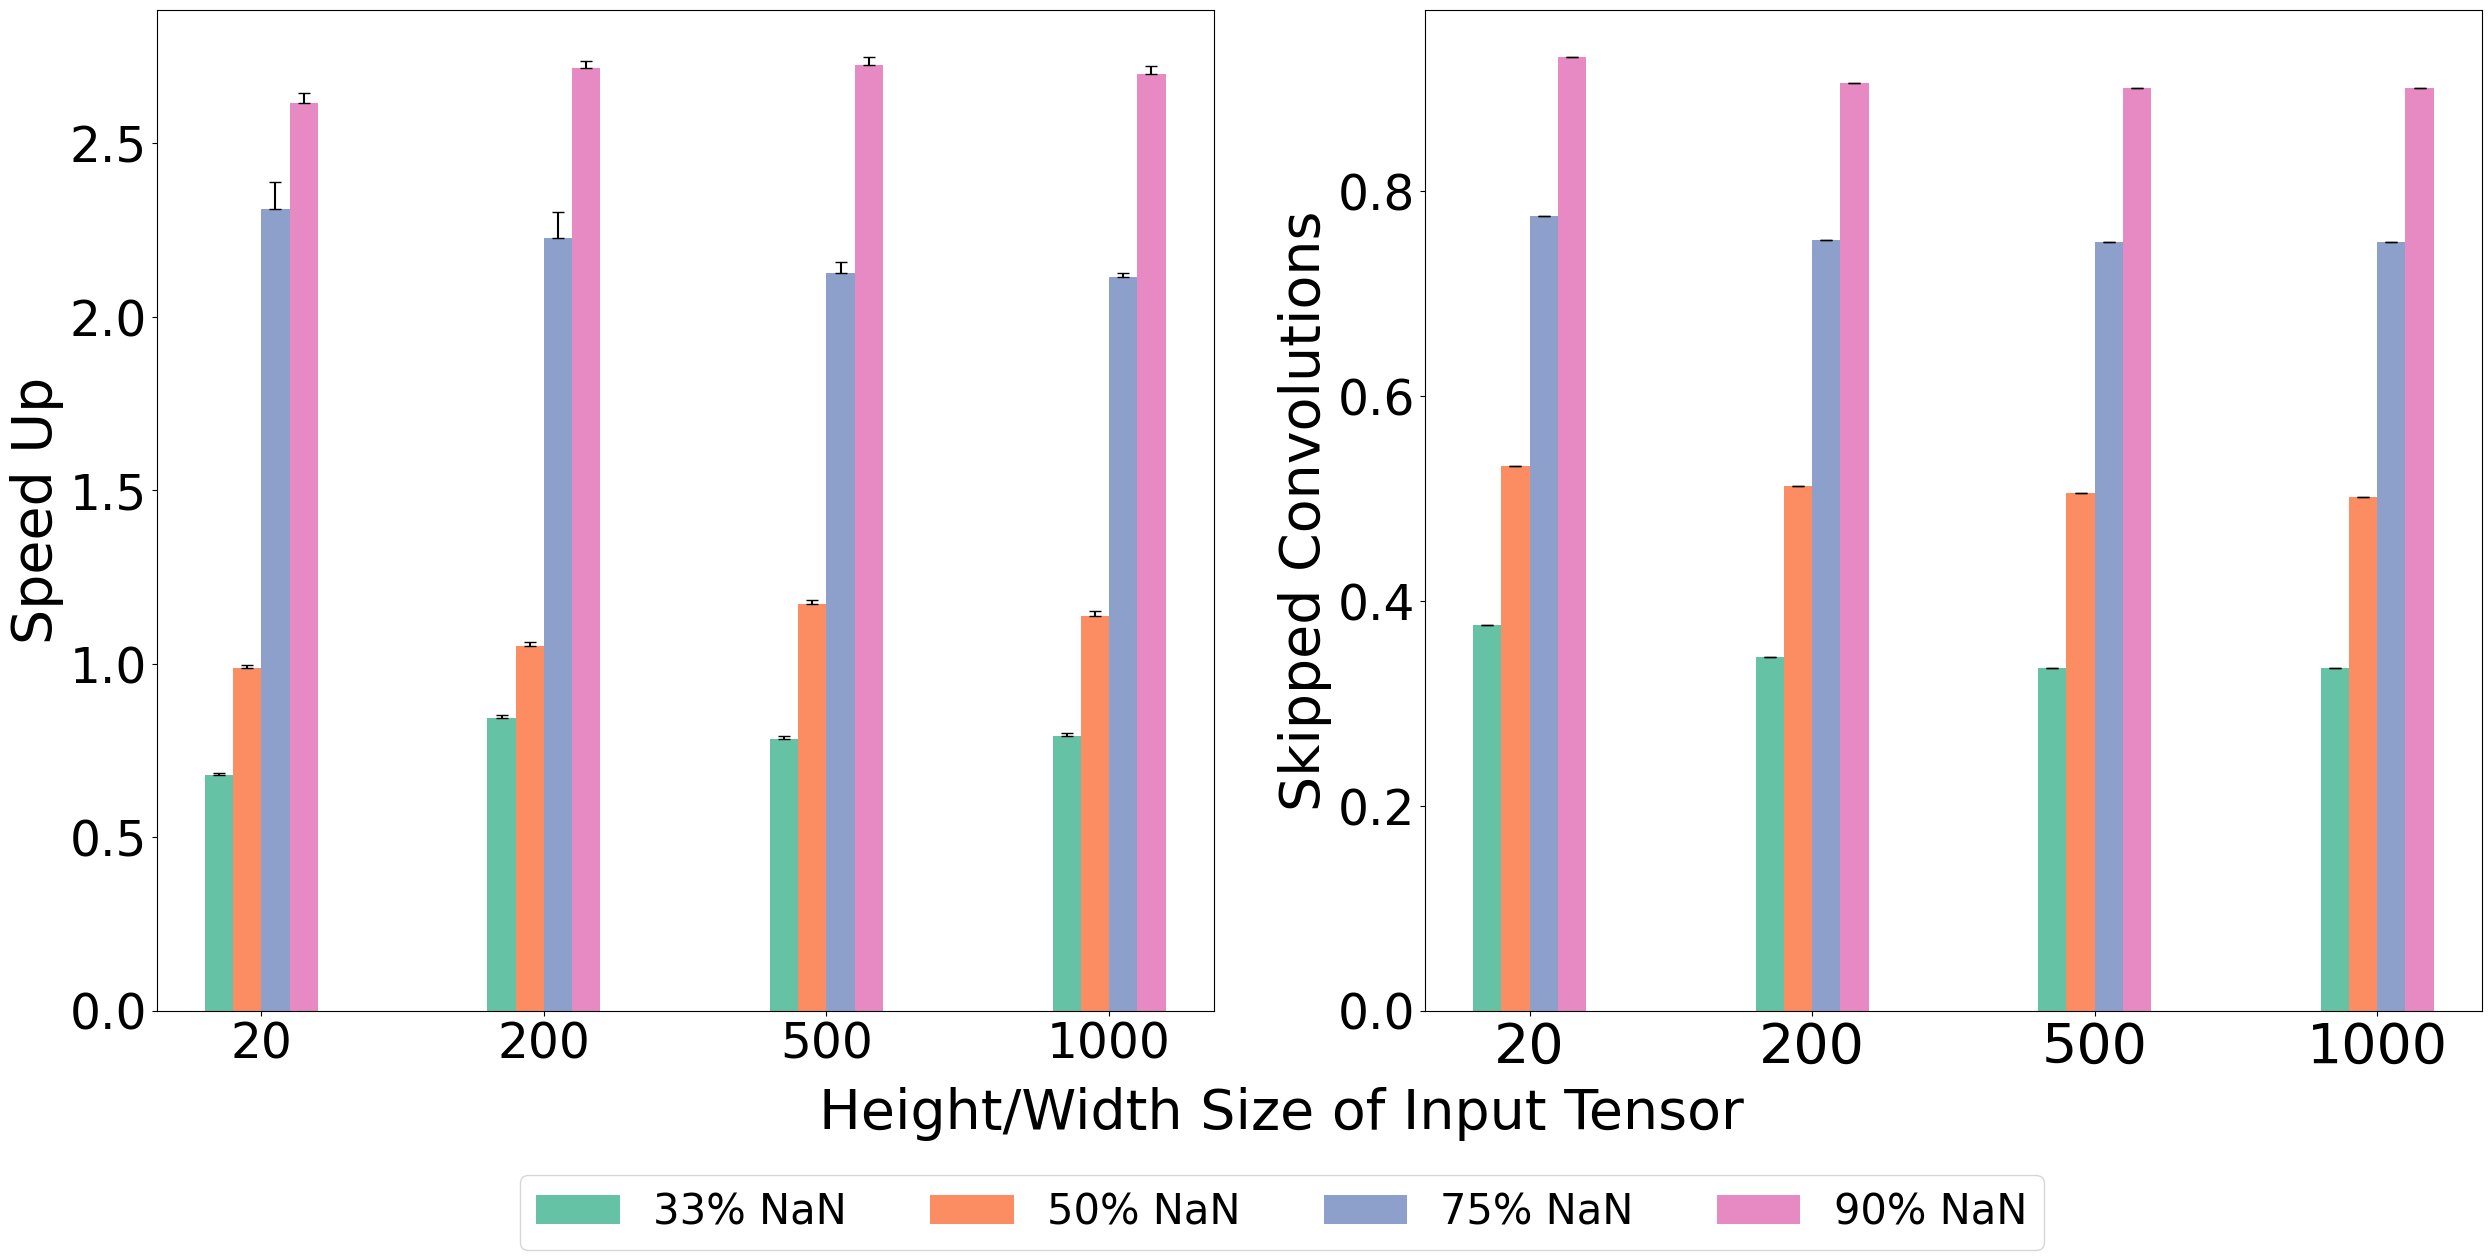

In [ ]:
# Load data
# Plot settings
selected_nan_presences = [1.5,2,4,10]
input_sizes = [20,200,500,1000]
n_groups = len(input_sizes)
bar_width = 0.1
x = np.arange(n_groups)

# Number of distinct lines/colors you want
N = 8  # Accent supports up to 8 distinct colors

cmap = cm.get_cmap('Set2')
# Generate N evenly spaced values from 0 to 1 to sample the colormap
colors = [cmap(i / N) for i in range(N)]

# cmap = cm.get_cmap('Set1')
# colors2 = [cmap(i / N) for i in range(N)]


basic_cputime_manual_idx = {k: [] for k in selected_nan_presences }
basic_cputime_nan_idx = {k: [] for k in selected_nan_presences }
# basic_cputime_manual_struct = {k: [] for k in selected_nan_presences }
# basic_cputime_nan_struct = {k: [] for k in selected_nan_presences }

for i in range(1, 11):
    tmp = pickle.load(open(f"basic_runtimes/random_idx_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in selected_nan_presences:
        basic_cputime_manual_idx[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan_idx[nan_presence].append(tmp[nan_presence]['NaNConv'])
    # tmp = pickle.load(open(f"basic_runtimes/nanconv_cputime_{i}.pkl", 'rb'))
    # for nan_presence in selected_nan_presences:
    #     basic_cputime_manual_struct[nan_presence].append(tmp[nan_presence]['ManualConv'])
    #     basic_cputime_nan_struct[nan_presence].append(tmp[nan_presence]['NaNConv'])


fig, ax = plt.subplots(1,2,figsize=(30, 13), )

# Loop through each selected NaN level and compute mean gains
for i, nan_presence in enumerate(selected_nan_presences):
    manual_times_idx = np.stack(basic_cputime_manual_idx[nan_presence])[:, [0,1,3,6]]
    nan_times_idx = np.stack(basic_cputime_nan_idx[nan_presence])[:, [0,1,3,6]]
    gains_idx = (manual_times_idx / nan_times_idx) #manual float32 vs float32 nanconv
    means_idx = gains_idx.mean(axis=0)
    stds_idx = gains_idx.std(axis=0)  
    print(nan_presence, nan_times_idx.mean(axis=0))
    print(nan_presence, manual_times_idx.mean(axis=0))
    
    # Bar offset per group
    offset = (i - len(selected_nan_presences) / 2) * bar_width + bar_width / 2
    ax[0].bar(x + offset, means_idx, yerr=[np.zeros_like(stds_idx), stds_idx], capsize=4, width=bar_width, color=colors[i], label=f"{(1 - 1/nan_presence) * 100:.0f}% NaN")

    # manual_times_struct = np.stack(basic_cputime_manual_struct[nan_presence])[:, [0,1,3,6]]
    # print(manual_times_struct.shape)
    # nan_times_struct = np.stack(basic_cputime_nan_struct[nan_presence])[:, [0,1,3,6]]
    # gains_struct = (manual_times_struct / nan_times_struct) #manual float32 vs float32 nanconv
    # means_struct = gains_struct.mean(axis=0)
    # print(nan_presence, means_struct)

    # # Bar offset per group
    # ax[0].bar(x + offset, means_struct, width=bar_width, color=colors[i], hatch='...', alpha=0.5, label=f"{(1 - 1/nan_presence) * 100:.0f}% Structured")

    #skipconv
    nan_times_skip = np.array(skip_cputime_nan_idx[nan_presence]).squeeze()
    # gains_struct = (manual_times_struct / nan_times_struct) #manual float32 vs float32 nanconv
    means_skip = nan_times_skip.mean(axis=0)
    stds_skip = nan_times_skip.std(axis=0)  

    ax[1].bar(x + offset, means_skip, yerr=[np.zeros_like(stds_skip), stds_skip], capsize=4, width=bar_width, color=colors[i], label=f"{(1 - 1/nan_presence) * 100:.0f}% NaN")

    # mean = skip_cputime_nan_idx[nan_presence].mean(axis=1).squeeze()
    # std = skip_cputime_nan_idx[nan_presence].std(axis=1).squeeze()
    # ax[1].plot(np.arange(len(mean)), mean, marker='o', color=colors[i], label=f'{(1 - ( matrix_size//nan_presence)/matrix_size)*100:.0f}%')
    # ax[1].fill_between(np.arange(len(mean)), mean-std, mean+std, color=colors[i], alpha=0.2)


# ax[0].set_xlabel('Height/Width Size of Input Tensor')
ax[0].set_xticks(x), 
ax[0].set_xticklabels(input_sizes, fontsize=40)
ax[0].tick_params(axis='both', labelsize=35), ax[1].tick_params(axis='both', labelsize=35)
# ax[0].legend(title="NaN Percentage", bbox_to_anchor=(1.05, 1), loc='upper left')

ax[0].set_ylabel('Speed Up', fontsize=40)
# ax[0].set_xlabel('Height/Width Size of Input Tensor', fontsize=40)

handles, labels = ax[0].get_legend_handles_labels()
# ax[0].legend(handles, labels, prop={'size': 30}, loc='upper left', bbox_to_anchor=(0.1, 1.2), ncol=2)

  
ax[1].set_xticks(np.arange(len(input_sizes)))
ax[1].set_xticklabels(input_sizes, fontsize=40)
ax[1].set_ylabel('Skipped Convolutions', fontsize=40)
handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles, labels, prop={'size': 30}, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
fig.legend(handles, labels, prop={'size': 30}, loc='upper center', bbox_to_anchor=(0.5, 0.), ncol=4)

fig.supxlabel('Height/Width Size of Input Tensor', fontsize=40)
# plt.legend(bbox_to_anchor=(1.02,1.0))

# plt.tight_layout()
plt.savefig(f'/home/inesgp/nanconv_unittests/basic_test_speedup.pdf', bbox_inches='tight');

# plt.show()


**Reduced Precision on GPU**

/tmp/ipykernel_2151035/1065601710.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2')


1.5 [0.97325929 0.78217411 0.7897768  0.76625708 0.77433509]
bfloat  1.5 [0.40741579 0.78086023 0.86527944 0.83018378 0.83129263]
2 [1.05801854 1.17975124 1.16834016 1.13737041 1.08758863]
bfloat  2 [1.36640918 1.28881138 1.05648279 1.18158976 1.17007144]
3 [2.03417203 1.69929964 1.57442573 1.70394646 1.62628158]
bfloat  3 [2.08285742 2.0390574  1.76684769 1.80492015 1.74244747]
4 [2.31862482 1.88755524 2.00251032 1.95672947 1.92952508]
bfloat  4 [2.18309221 2.10496995 2.12974847 2.19418743 2.10496932]
10 [2.42677843 2.46165394 2.44835732 2.3589148  2.40905198]
bfloat  10 [2.26504876 2.56095609 2.57013165 2.51494042 2.54510868]


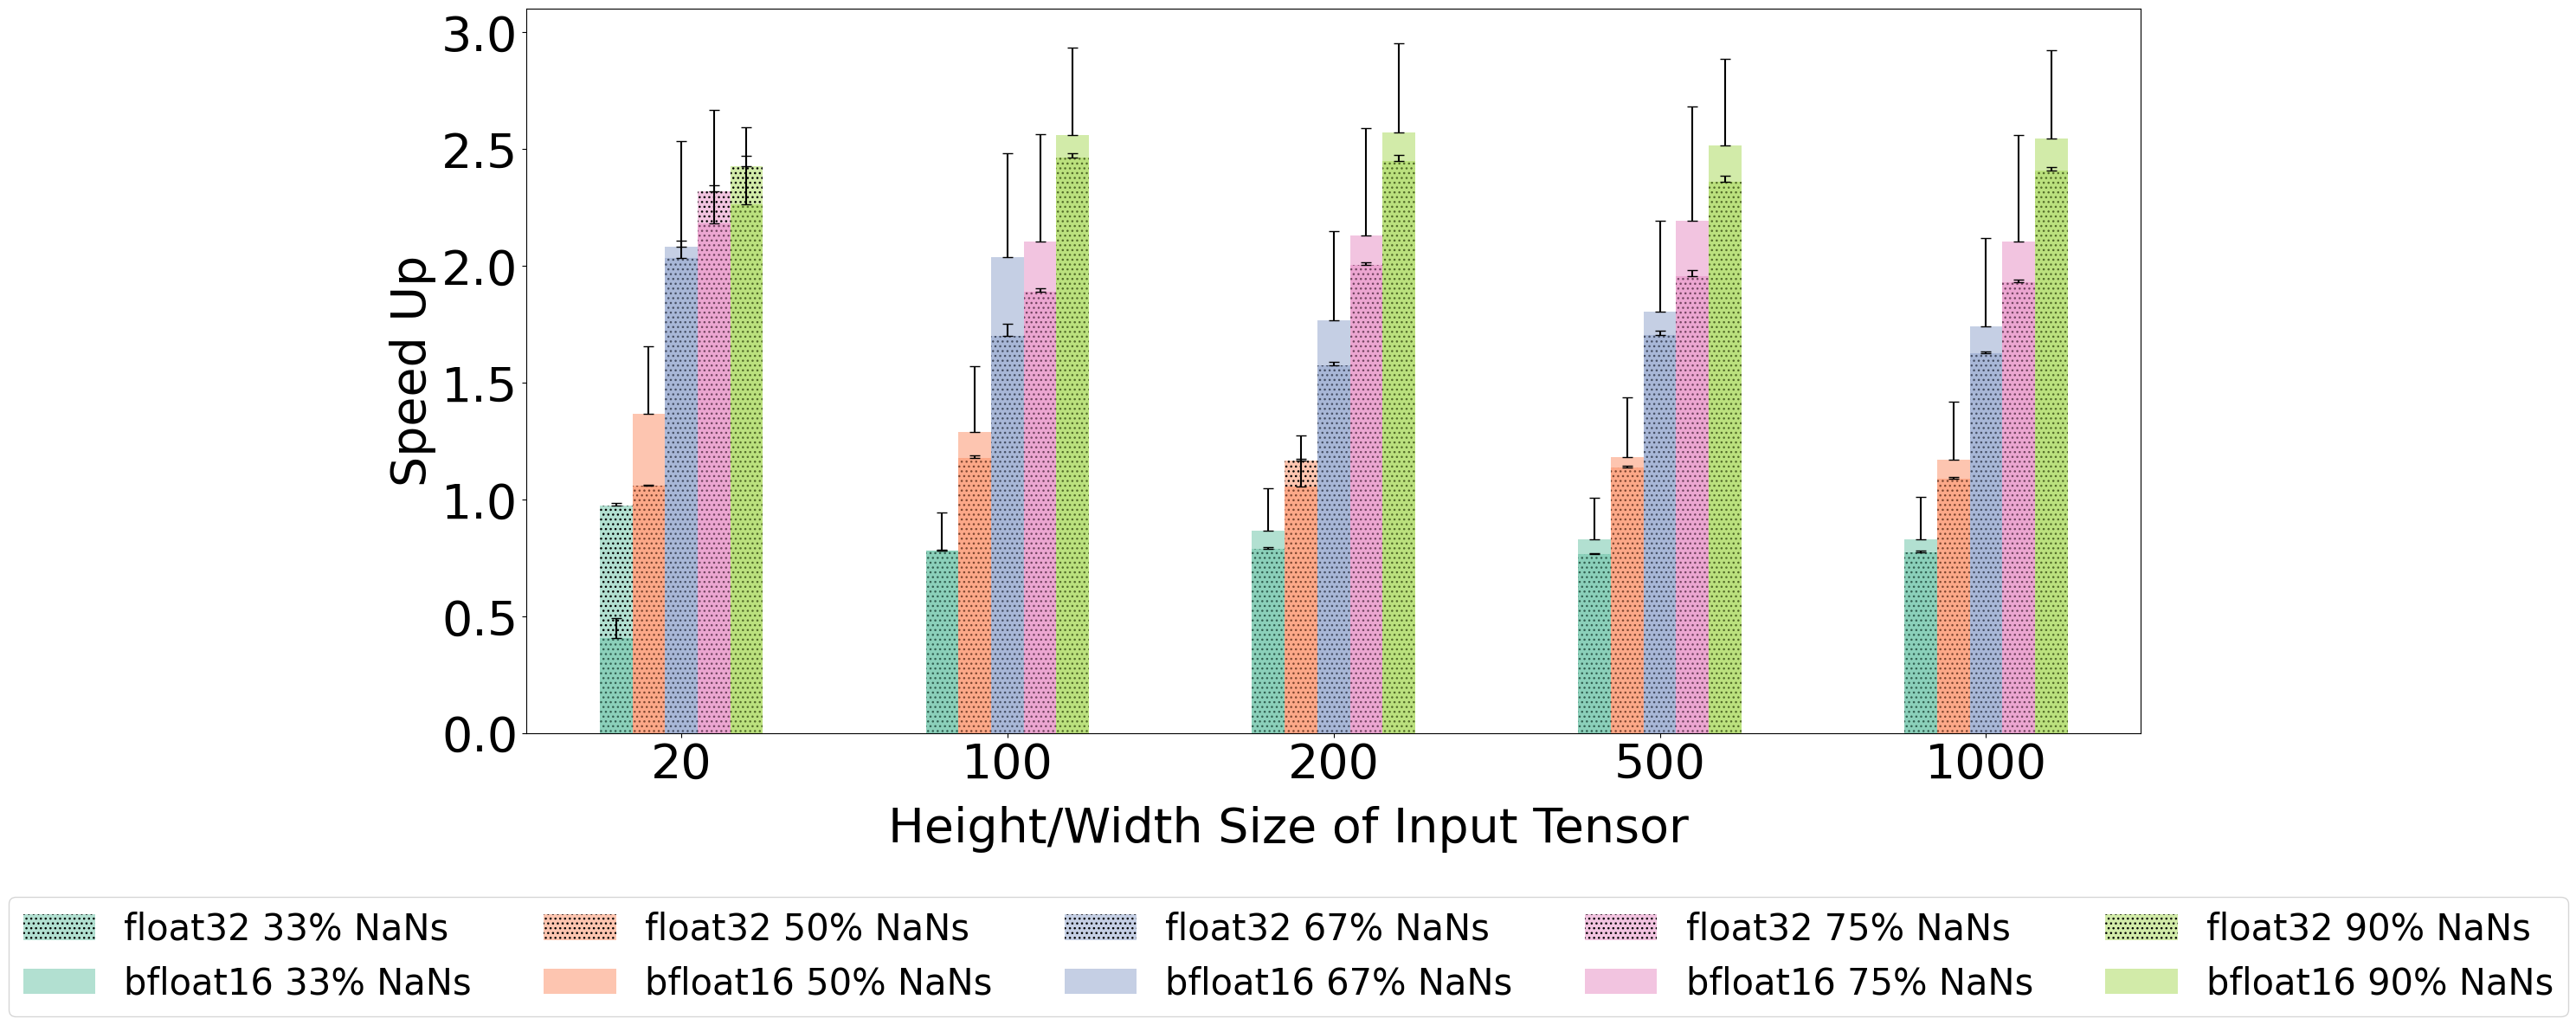

In [ ]:
# Load data
# Plot settings
selected_nan_presences = [1.5,2,3,4,10]
input_sizes = [20,100,200,500,1000]
n_groups = len(input_sizes)
bar_width = 0.1
x = np.arange(n_groups)

# Number of distinct lines/colors you want
N = 8  # Accent supports up to 8 distinct colors

# Get the Accent colormap
cmap = cm.get_cmap('Set2')
# Generate N evenly spaced values from 0 to 1 to sample the colormap
colors = [cmap(i / N) for i in range(N)]


basic_cputime_manual_idx = {k: [] for k in selected_nan_presences }
basic_cputime_nan_idx = {k: [] for k in selected_nan_presences }
basic_cputime_manual_struct = {k: [] for k in selected_nan_presences }
basic_cputime_nan_struct = {k: [] for k in selected_nan_presences }
basic_cputime_manual_idx_bfloat = {k: [] for k in selected_nan_presences }
basic_cputime_nan_idx_bfloat = {k: [] for k in selected_nan_presences }
basic_cputime_manual_struct_bfloat = {k: [] for k in selected_nan_presences }
basic_cputime_nan_struct_bfloat = {k: [] for k in selected_nan_presences }

for i in range(1, 11):
    tmp = pickle.load(open(f"basic_runtimes/gpu_float32_random_idx_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in selected_nan_presences:
        basic_cputime_manual_idx[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan_idx[nan_presence].append(tmp[nan_presence]['NaNConv'])
    tmp = pickle.load(open(f"basic_runtimes/gpu_float32_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in selected_nan_presences:
        basic_cputime_manual_struct[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan_struct[nan_presence].append(tmp[nan_presence]['NaNConv'])

    tmp = pickle.load(open(f"basic_runtimes/gpu_bfloat16_random_idx_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in selected_nan_presences:
        basic_cputime_manual_idx_bfloat[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan_idx_bfloat[nan_presence].append(tmp[nan_presence]['NaNConv'])
    tmp = pickle.load(open(f"basic_runtimes/gpu_bfloat16_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in selected_nan_presences:
        basic_cputime_manual_struct_bfloat[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan_struct_bfloat[nan_presence].append(tmp[nan_presence]['NaNConv'])

fig, ax = plt.subplots(1,1,figsize=(20, 10), sharey=True)

# Loop through each selected NaN level and compute mean gains
for i, nan_presence in enumerate(selected_nan_presences):
    manual_times_idx = np.stack(basic_cputime_manual_idx[nan_presence])[:, [0,1,2,3,6]]
    nan_times_idx = np.stack(basic_cputime_nan_idx[nan_presence])[:, [0,1,2,3,6]]
    gains_idx = (manual_times_idx / nan_times_idx) #manual float32 vs float32 nanconv
    means_idx = gains_idx.mean(axis=0)
    std_idx = gains_idx.std(axis=0)
    print(nan_presence, means_idx)

    manual_times_idx_bfloat = np.stack(basic_cputime_manual_idx_bfloat[nan_presence])[:, [0,1,2,3,6]]
    nan_times_idx_bfloat = np.stack(basic_cputime_nan_idx_bfloat[nan_presence])[:, [0,1,2,3,6]]
    gains_idx_bfloat = (manual_times_idx / nan_times_idx_bfloat) #manual float32 vs bfloat16 nanconv
    means_idx_bfloat = gains_idx_bfloat.mean(axis=0)
    std_idx_bfloat = gains_idx_bfloat.std(axis=0)
    print('bfloat ', nan_presence, means_idx_bfloat)
    
    # Bar offset per group
    offset = (i - len(selected_nan_presences) / 2) * bar_width + bar_width / 2
    # offset = (i - len(selected_nan_presences) ) * bar_width + bar_width / 2
    ax.bar(x + offset, means_idx, width=bar_width, yerr=[np.zeros_like(std_idx), std_idx], capsize=4, color=colors[i], alpha=0.5, hatch='...', label=f"float32 {(1 - 1/nan_presence) * 100:.0f}% NaNs")
    ax.bar(x + offset, means_idx_bfloat, width=bar_width, yerr=[np.zeros_like(std_idx_bfloat), std_idx_bfloat], capsize=4, color=colors[i], alpha=0.5, label=f"bfloat16 {(1 - 1/nan_presence) * 100:.0f}% NaNs")
# ax[0].set_xlabel('Height/Width Size of Input Tensor')
ax.set_xticks(x)
ax.set_xticklabels(input_sizes, fontsize=40)
# ax.set_title('Randomized NaNs', fontsize=50)
ax.tick_params(axis='both', labelsize=40)
# ax[0].legend(title="NaN Percentage", bbox_to_anchor=(1.05, 1), loc='upper left')

# for i, nan_presence in enumerate(selected_nan_presences):
#     manual_times_struct = np.stack(basic_cputime_manual_struct[nan_presence])[:, [0,1,2,3,6]]
#     nan_times_struct = np.stack(basic_cputime_nan_struct[nan_presence])[:, [0,1,2,3,6]]
#     gains_struct = (manual_times_struct / nan_times_struct) #manual float32 vs float32 nanconv
#     means_struct = gains_struct.mean(axis=0)
#     print(nan_presence, means_struct)

#     manual_times_struct_bfloat = np.stack(basic_cputime_manual_struct_bfloat[nan_presence])[:, [0,1,2,3,6]]
#     nan_times_struct_bfloat = np.stack(basic_cputime_nan_struct_bfloat[nan_presence])[:, [0,1,2,3,6]]
#     gains_struct_bfloat = (manual_times_struct / nan_times_struct_bfloat) #manual float32 vs bfloat16 nanconv
#     means_struct_bfloat = gains_struct_bfloat.mean(axis=0)
#     print('bfloat ', nan_presence, means_struct_bfloat)

#     # Bar offset per group
#     offset = (i - len(selected_nan_presences) / 2) * bar_width + bar_width / 2
#     ax[1].bar(x + offset, means_struct, width=bar_width, color=colors[i], alpha=0.5,  label=f"float32 {(1 - 1/nan_presence) * 100:.0f}% NaNs")
#     ax[1].bar(x + offset, means_struct_bfloat, width=bar_width, color=colors[i], hatch='...', alpha=0.5, label=f"bfloat16 {(1 - 1/nan_presence) * 100:.0f}% NaNs")

# # ax[1].set_xlabel('Height/Width Size of Input Tensor')
# ax[1].set_xticks(x)
# ax[1].set_xticklabels(input_sizes, fontsize=40)
# ax[1].set_title('Structured NaNs', fontsize=60)
# ax[1].tick_params(axis='both', labelsize=40)

ax.set_ylabel('Speed Up', fontsize=40)
fig.supxlabel('Height/Width Size of Input Tensor', fontsize=40)
# fig.suptitle('Average CPU Time Speed Up Between Manual and NaN Convolutions')
# ax[1].legend(title="NaN Percentage", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=40)

# ax.axhline(0, color='black', linestyle='--')
# ax.set_ylim(-0.05,2)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, prop={'size': 30}, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5)

plt.tight_layout()
plt.savefig(f'/home/inesgp/nanconv_unittests/gpu_reduced_prec_basic_test_speedup.pdf', bbox_inches='tight');

# plt.show()


**Reduced Precision on CPU**

/tmp/ipykernel_2040276/1669837587.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2')


1.5 [0.76093991 0.76791909 0.78363321 0.75181824 0.77261556]
bfloat  1.5 [0.83756767 0.74939796 0.77592351 0.75551891 0.74275427]
2 [1.0270849  1.16279111 1.155148   1.12590871 1.0820297 ]
bfloat  2 [1.09028017 0.90937336 1.01385068 0.93509575 0.8993377 ]
3 [1.96944467 1.70226211 1.56078223 1.68003353 1.6107341 ]
bfloat  3 [1.64783988 1.34650322 1.34423863 1.19128728 1.15778747]
4 [2.24283095 1.85596691 1.97206662 1.92241952 1.90815443]
bfloat  4 [1.67729259 1.35423261 1.34250905 1.39221285 1.32449635]
10 [2.35516018 2.42675264 2.42629529 2.33338132 2.37855515]
bfloat  10 [2.29504619 1.97492846 2.21052006 1.99391647 1.87168895]
1.5 [0.8101229  0.74163714 0.76569017 0.74755613 0.7376953 ]
bfloat  1.5 [0.76785396 0.72479738 0.81048654 0.77370238 0.78309837]
2 [1.08701225 0.90482323 1.00345623 0.92866801 0.89716077]
bfloat  2 [1.12587189 1.09247177 0.89810067 0.99531794 0.99184747]
3 [1.62186833 1.33689004 1.32985734 1.19061698 1.15196706]
bfloat  3 [1.69673331 1.70579871 1.47574118 1.524

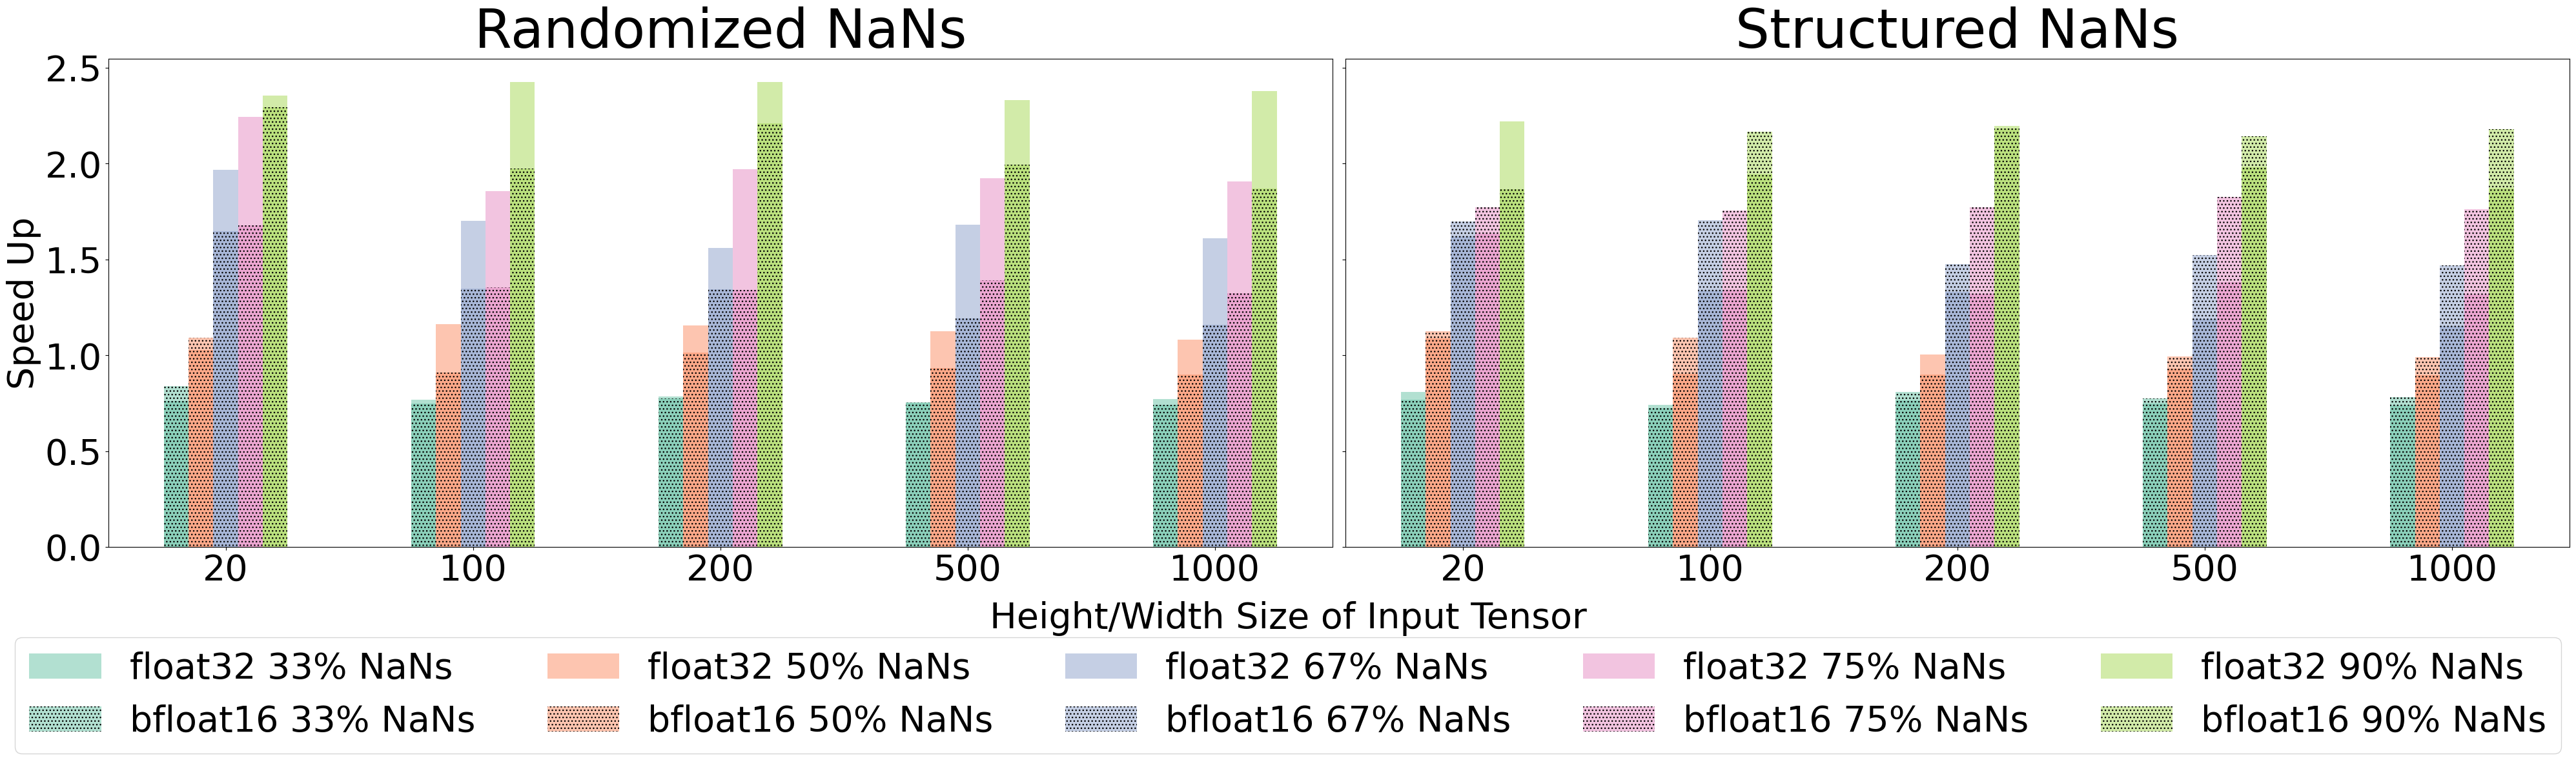

In [4]:
# Load data
# Plot settings
selected_nan_presences = [1.5,2,3,4,10]
input_sizes = [20,100,200,500,1000]
n_groups = len(input_sizes)
bar_width = 0.1
x = np.arange(n_groups)

# Number of distinct lines/colors you want
N = 8  # Accent supports up to 8 distinct colors

# Get the Accent colormap
cmap = cm.get_cmap('Set2')
# Generate N evenly spaced values from 0 to 1 to sample the colormap
colors = [cmap(i / N) for i in range(N)]


basic_cputime_manual_idx = {k: [] for k in selected_nan_presences }
basic_cputime_nan_idx = {k: [] for k in selected_nan_presences }
basic_cputime_manual_struct = {k: [] for k in selected_nan_presences }
basic_cputime_nan_struct = {k: [] for k in selected_nan_presences }
basic_cputime_manual_idx_bfloat = {k: [] for k in selected_nan_presences }
basic_cputime_nan_idx_bfloat = {k: [] for k in selected_nan_presences }
basic_cputime_manual_struct_bfloat = {k: [] for k in selected_nan_presences }
basic_cputime_nan_struct_bfloat = {k: [] for k in selected_nan_presences }

for i in range(1, 11):
    tmp = pickle.load(open(f"basic_runtimes/float32_random_idx_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in selected_nan_presences:
        basic_cputime_manual_idx[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan_idx[nan_presence].append(tmp[nan_presence]['NaNConv'])
    tmp = pickle.load(open(f"basic_runtimes/float32_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in selected_nan_presences:
        basic_cputime_manual_struct[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan_struct[nan_presence].append(tmp[nan_presence]['NaNConv'])

    tmp = pickle.load(open(f"basic_runtimes/bfloat16_random_idx_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in selected_nan_presences:
        basic_cputime_manual_idx_bfloat[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan_idx_bfloat[nan_presence].append(tmp[nan_presence]['NaNConv'])
    tmp = pickle.load(open(f"basic_runtimes/bfloat16_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in selected_nan_presences:
        basic_cputime_manual_struct_bfloat[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan_struct_bfloat[nan_presence].append(tmp[nan_presence]['NaNConv'])

fig, ax = plt.subplots(1,2,figsize=(40, 10), sharey=True)

# Loop through each selected NaN level and compute mean gains
for i, nan_presence in enumerate(selected_nan_presences):
    manual_times_idx = np.stack(basic_cputime_manual_idx[nan_presence])[:, [0,1,2,3,6]]
    nan_times_idx = np.stack(basic_cputime_nan_idx[nan_presence])[:, [0,1,2,3,6]]
    gains_idx = (manual_times_idx / nan_times_idx) #manual float32 vs float32 nanconv
    means_idx = gains_idx.mean(axis=0)
    print(nan_presence, means_idx)

    manual_times_idx_bfloat = np.stack(basic_cputime_manual_idx_bfloat[nan_presence])[:, [0,1,2,3,6]]
    nan_times_idx_bfloat = np.stack(basic_cputime_nan_idx_bfloat[nan_presence])[:, [0,1,2,3,6]]
    gains_idx_bfloat = (manual_times_idx / nan_times_idx_bfloat) #manual float32 vs bfloat16 nanconv
    means_idx_bfloat = gains_idx_bfloat.mean(axis=0)
    print('bfloat ', nan_presence, means_idx_bfloat)
    
    # Bar offset per group
    offset = (i - len(selected_nan_presences) / 2) * bar_width + bar_width / 2
    # offset = (i - len(selected_nan_presences) ) * bar_width + bar_width / 2
    ax[0].bar(x + offset, means_idx, width=bar_width, color=colors[i], alpha=0.5, label=f"float32 {(1 - 1/nan_presence) * 100:.0f}% NaNs")
    ax[0].bar(x + offset, means_idx_bfloat, width=bar_width, color=colors[i], hatch='...', alpha=0.5, label=f"bfloat16 {(1 - 1/nan_presence) * 100:.0f}% NaNs")
# ax[0].set_xlabel('Height/Width Size of Input Tensor')
ax[0].set_xticks(x)
ax[0].set_xticklabels(input_sizes, fontsize=40)
ax[0].set_title('Randomized NaNs', fontsize=60)
ax[0].tick_params(axis='both', labelsize=40)
# ax[0].legend(title="NaN Percentage", bbox_to_anchor=(1.05, 1), loc='upper left')

for i, nan_presence in enumerate(selected_nan_presences):
    manual_times_struct = np.stack(basic_cputime_manual_struct[nan_presence])[:, [0,1,2,3,6]]
    nan_times_struct = np.stack(basic_cputime_nan_struct[nan_presence])[:, [0,1,2,3,6]]
    gains_struct = (manual_times_struct / nan_times_struct) #manual float32 vs float32 nanconv
    means_struct = gains_struct.mean(axis=0)
    print(nan_presence, means_struct)

    manual_times_struct_bfloat = np.stack(basic_cputime_manual_struct_bfloat[nan_presence])[:, [0,1,2,3,6]]
    nan_times_struct_bfloat = np.stack(basic_cputime_nan_struct_bfloat[nan_presence])[:, [0,1,2,3,6]]
    gains_struct_bfloat = (manual_times_struct / nan_times_struct_bfloat) #manual float32 vs bfloat16 nanconv
    means_struct_bfloat = gains_struct_bfloat.mean(axis=0)
    print('bfloat ', nan_presence, means_struct_bfloat)

    # Bar offset per group
    offset = (i - len(selected_nan_presences) / 2) * bar_width + bar_width / 2
    ax[1].bar(x + offset, means_struct, width=bar_width, color=colors[i], alpha=0.5,  label=f"float32 {(1 - 1/nan_presence) * 100:.0f}% NaNs")
    ax[1].bar(x + offset, means_struct_bfloat, width=bar_width, color=colors[i], hatch='...', alpha=0.5, label=f"bfloat16 {(1 - 1/nan_presence) * 100:.0f}% NaNs")

# ax[1].set_xlabel('Height/Width Size of Input Tensor')
ax[1].set_xticks(x)
ax[1].set_xticklabels(input_sizes, fontsize=40)
ax[1].set_title('Structured NaNs', fontsize=60)
ax[1].tick_params(axis='both', labelsize=40)

ax[0].set_ylabel('Speed Up', fontsize=40)
fig.supxlabel('Height/Width Size of Input Tensor', fontsize=40)
# fig.suptitle('Average CPU Time Speed Up Between Manual and NaN Convolutions')
# ax[1].legend(title="NaN Percentage", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=40)

# ax.axhline(0, color='black', linestyle='--')
# ax.set_ylim(-0.05,2)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, prop={'size': 40}, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5)

plt.tight_layout()
plt.savefig(f'/home/inesgp/nanconv_unittests/cpu_reduced_prec_basic_test_speedup.pdf', bbox_inches='tight');

# plt.show()


#### Supplementary Figures

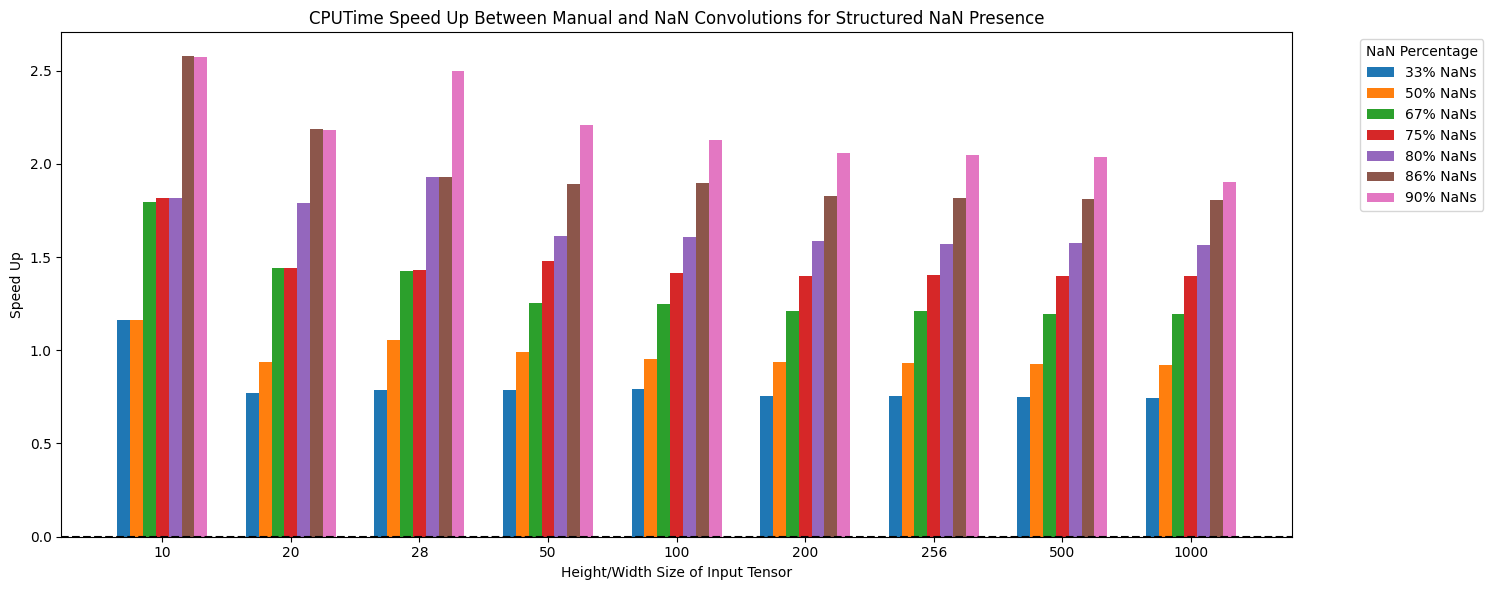

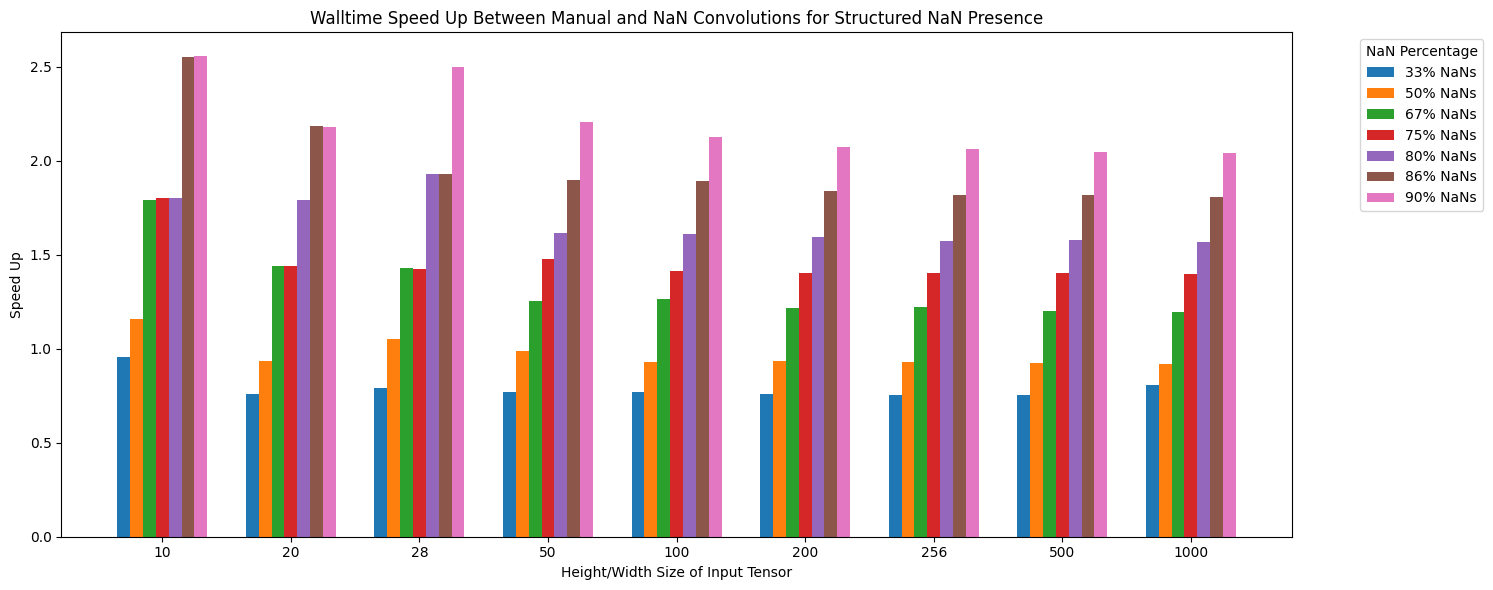

In [ ]:
# Load data
basic_cputime_manual = {k: [] for k in [1.5,2,3,4,5,7,10]}
basic_cputime_nan = {k: [] for k in [1.5,2,3,4,5,7,10]}

for i in range(1, 11):
    tmp = pickle.load(open(f"basic_runtimes/nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in [1.5,2,3,4,5,7,10]:
        basic_cputime_manual[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan[nan_presence].append(tmp[nan_presence]['NaNConv'])

# Plot settings
selected_nan_presences = [1.5,2,3,4,5,7,10]
# input_sizes = [5, 10, 20, 50, 100, 200, 500, 1000]
input_sizes = [10,20,28,50,100,200,256,500,1000]
n_groups = len(input_sizes)
bar_width = 0.1
x = np.arange(n_groups)

fig, ax = plt.subplots(figsize=(15, 6))

# Loop through each selected NaN level and compute mean gains
for i, nan_presence in enumerate(selected_nan_presences):
    manual_times = np.stack(basic_cputime_manual[nan_presence])
    nan_times = np.stack(basic_cputime_nan[nan_presence])
    gains = (manual_times / nan_times) #/ manual_times * 100
    means = gains.mean(axis=0)

    # Bar offset per group
    offset = (i - len(selected_nan_presences) / 2) * bar_width + bar_width / 2
    ax.bar(x + offset, means, width=bar_width, label=f"{(1 - 1/nan_presence) * 100:.0f}% NaNs")

ax.set_ylabel('Speed Up')
ax.set_xlabel('Height/Width Size of Input Tensor')
ax.set_title('CPUTime Speed Up Between Manual and NaN Convolutions for Structured NaN Presence')
ax.set_xticks(x)
ax.set_xticklabels(input_sizes)
ax.axhline(0, color='black', linestyle='--')
# ax.set_ylim(-0.05,2)
ax.legend(title="NaN Percentage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Load data
basic_walltime_manual = {k: [] for k in [1.5,2,3,4,5,7,10]}
basic_walltime_nan = {k: [] for k in [1.5,2,3,4,5,7,10]}

for i in range(1, 11):
    tmp = pickle.load(open(f"basic_runtimes/nanconv_walltime_{i}.pkl", 'rb'))
    for nan_presence in [1.5,2,3,4,5,7,10]:
        basic_walltime_manual[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_walltime_nan[nan_presence].append(tmp[nan_presence]['NaNConv'])

# Plot settings
selected_nan_presences = [1.5,2,3,4,5,7,10] # [2, 3, 4, 5, 7, 10]
# input_sizes = [5, 10, 20, 50, 100, 200, 500, 1000]
input_sizes = [10,20,28,50,100,200,256,500,1000]
n_groups = len(input_sizes)
bar_width = 0.1
x = np.arange(n_groups)

fig, ax = plt.subplots(figsize=(15, 6))

# Loop through each selected NaN level and compute mean gains
for i, nan_presence in enumerate(selected_nan_presences):
    manual_times = np.stack(basic_walltime_manual[nan_presence])
    nan_times = np.stack(basic_walltime_nan[nan_presence])
    gains = (manual_times / nan_times) #/ manual_times * 100
    means = gains.mean(axis=0)

    # Bar offset per group
    offset = (i - len(selected_nan_presences) / 2) * bar_width + bar_width / 2
    ax.bar(x + offset, means, width=bar_width, label=f"{(1 - 1/nan_presence) * 100:.0f}% NaNs")

ax.set_ylabel('Speed Up')
ax.set_xlabel('Height/Width Size of Input Tensor')
ax.set_title('Walltime Speed Up Between Manual and NaN Convolutions for Structured NaN Presence')
ax.set_xticks(x)
ax.set_xticklabels(input_sizes)
# ax.axhline(0, color='black', linestyle='--')
# ax.set_ylim(-0.05,2)
ax.legend(title="NaN Percentage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


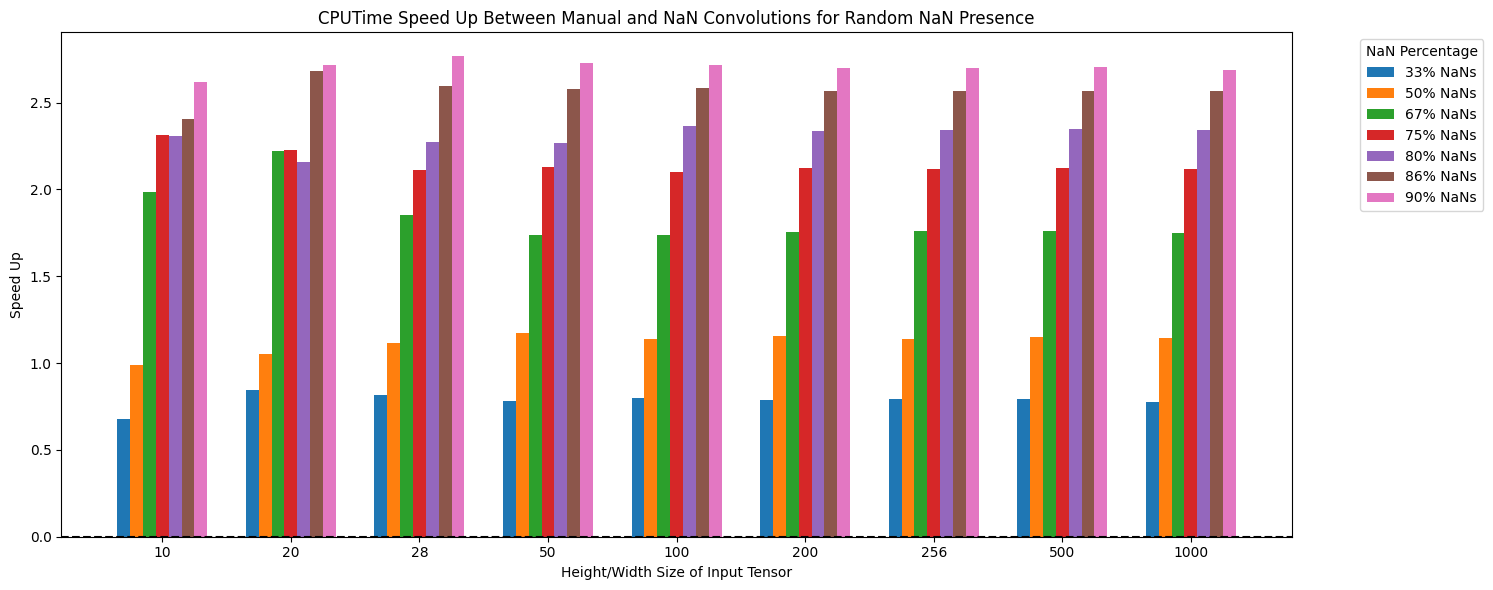

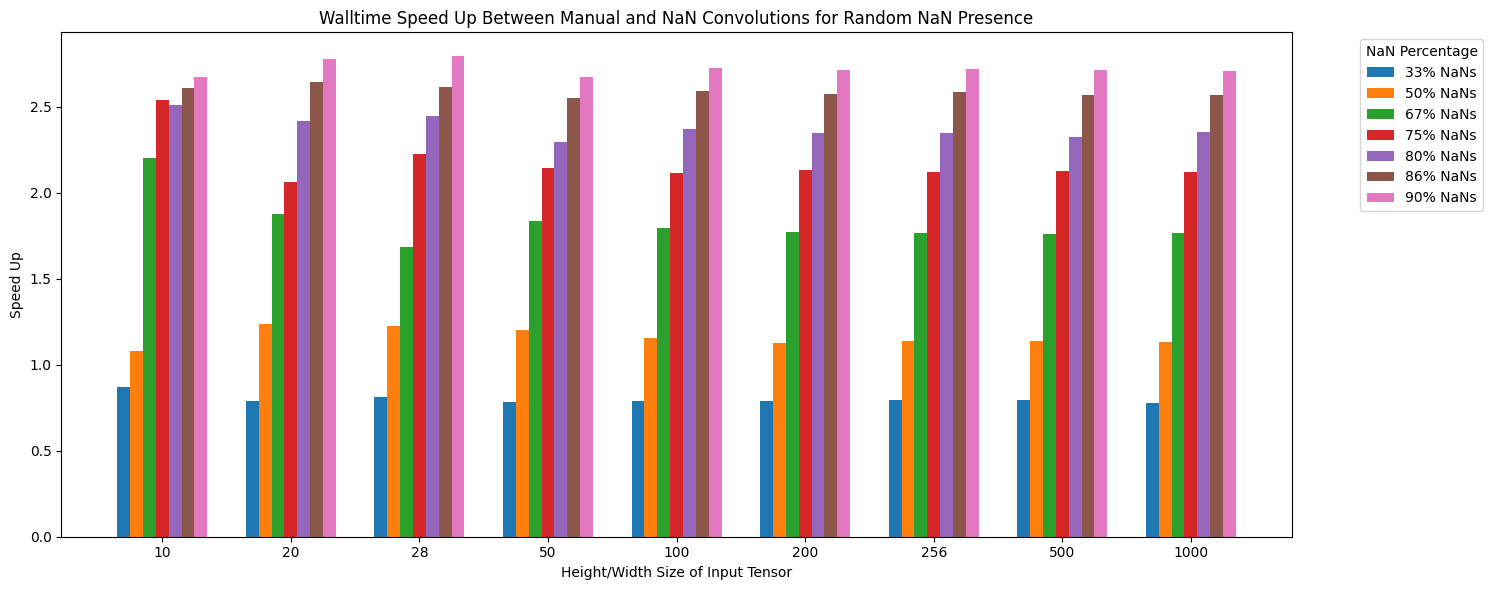

In [ ]:
# Load data
basic_cputime_manual = {k: [] for k in [1.5,2,3,4,5,7,10]}
basic_cputime_nan = {k: [] for k in [1.5,2,3,4,5,7,10]}

for i in range(1, 11):
    tmp = pickle.load(open(f"basic_runtimes/random_idx_nanconv_cputime_{i}.pkl", 'rb'))
    for nan_presence in [1.5,2,3,4,5,7,10]:
        basic_cputime_manual[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_cputime_nan[nan_presence].append(tmp[nan_presence]['NaNConv'])

# Plot settings
selected_nan_presences = [1.5,2,3,4,5,7,10]
# input_sizes = [5, 10, 20, 50, 100, 200, 500, 1000]
input_sizes = [10,20,28,50,100,200,256,500,1000]
n_groups = len(input_sizes)
bar_width = 0.1
x = np.arange(n_groups)

fig, ax = plt.subplots(figsize=(15, 6))

# Loop through each selected NaN level and compute mean gains
for i, nan_presence in enumerate(selected_nan_presences):
    manual_times = np.stack(basic_cputime_manual[nan_presence])
    nan_times = np.stack(basic_cputime_nan[nan_presence])
    gains = (manual_times / nan_times) #/ manual_times * 100
    means = gains.mean(axis=0)

    # Bar offset per group
    offset = (i - len(selected_nan_presences) / 2) * bar_width + bar_width / 2
    ax.bar(x + offset, means, width=bar_width, label=f"{(1 - 1/nan_presence) * 100:.0f}% NaNs")

ax.set_ylabel('Speed Up')
ax.set_xlabel('Height/Width Size of Input Tensor')
ax.set_title('CPUTime Speed Up Between Manual and NaN Convolutions for Random NaN Presence')
ax.set_xticks(x)
ax.set_xticklabels(input_sizes)
ax.axhline(0, color='black', linestyle='--')
# ax.set_ylim(-0.05,2)
ax.legend(title="NaN Percentage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Load data
basic_walltime_manual = {k: [] for k in [1.5,2,3,4,5,7,10]}
basic_walltime_nan = {k: [] for k in [1.5,2,3,4,5,7,10]}

for i in range(1, 11):
    tmp = pickle.load(open(f"basic_runtimes/random_idx_nanconv_walltime_{i}.pkl", 'rb'))
    for nan_presence in [1.5,2,3,4,5,7,10]:
        basic_walltime_manual[nan_presence].append(tmp[nan_presence]['ManualConv'])
        basic_walltime_nan[nan_presence].append(tmp[nan_presence]['NaNConv'])

# Plot settings
selected_nan_presences = [1.5,2,3,4,5,7,10] # [2, 3, 4, 5, 7, 10]
# input_sizes = [5, 10, 20, 50, 100, 200, 500, 1000]
input_sizes = [10,20,28,50,100,200,256,500,1000]
n_groups = len(input_sizes)
bar_width = 0.1
x = np.arange(n_groups)

fig, ax = plt.subplots(figsize=(15, 6))

# Loop through each selected NaN level and compute mean gains
for i, nan_presence in enumerate(selected_nan_presences):
    manual_times = np.stack(basic_walltime_manual[nan_presence])
    nan_times = np.stack(basic_walltime_nan[nan_presence])
    gains = (manual_times / nan_times) #/ manual_times * 100
    means = gains.mean(axis=0)

    # Bar offset per group
    offset = (i - len(selected_nan_presences) / 2) * bar_width + bar_width / 2
    ax.bar(x + offset, means, width=bar_width, label=f"{(1 - 1/nan_presence) * 100:.0f}% NaNs")

ax.set_ylabel('Speed Up')
ax.set_xlabel('Height/Width Size of Input Tensor')
ax.set_title('Walltime Speed Up Between Manual and NaN Convolutions for Random NaN Presence')
ax.set_xticks(x)
ax.set_xticklabels(input_sizes)
# ax.axhline(0, color='black', linestyle='--')
# ax.set_ylim(-0.05,2)
ax.legend(title="NaN Percentage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
